In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfigurasi File
excel_filename = 'BBM AAB.xlsx'

def audit_populasi_alat(filename):
    print("AUDIT POPULASI (MENCARI SEMUA JENIS ALAT)")    
    daftar_alat = []
    
    try:
        xls = pd.ExcelFile(filename)
        for sheet_name in xls.sheet_names:
            # Baca 3 baris pertama saja (Header)
            df = pd.read_excel(xls, sheet_name=sheet_name, header=None, nrows=3)
            
            # Baris 0 = Nama Unit, Baris 1 = Group KPI
            if df.shape[0] < 2: continue
            
            units = df.iloc[0].ffill()
            kpis = df.iloc[1].ffill()
            
            for col in range(1, df.shape[1]):
                u_name = units[col]
                k_name = kpis[col]
                
                if pd.notna(u_name):
                    # Simpan kombinasi unik (Nama Unit + KPI)
                    daftar_alat.append({
                        'Unit_Asli': str(u_name).strip().upper(),
                        'KPI_Asli': str(k_name).strip().upper() if pd.notna(k_name) else "KOSONG"
                    })
                    
    except Exception as e:
        print(f"Error Audit: {e}")
        return pd.DataFrame()

    # Hapus Duplikat
    df_audit = pd.DataFrame(daftar_alat).drop_duplicates()
    df_audit.sort_values(by=['KPI_Asli', 'Unit_Asli'], inplace=True)
    
    print(f"Terdapat {len(df_audit)} jenis alat.")
    return df_audit

# Jalankan Audit
df_audit = audit_populasi_alat(excel_filename)

# Tampilkan Hasil Audit (Untuk Pengecekan Mata Kepala Sendiri)
if not df_audit.empty:
    print("\nCONTOH DATA YANG DITEMUKAN")
    # Tampilkan 20 sampel acak atau filter khusus
    print(df_audit.head(10)) 

AUDIT POPULASI (MENCARI SEMUA JENIS ALAT)
Terdapat 338 jenis alat.

CONTOH DATA YANG DITEMUKAN
         Unit_Asli        KPI_Asli
732         AKASIA  28T DOWN - (-)
847         ALPINE  28T DOWN - (-)
682           ATOZ  28T DOWN - (-)
742      BANTENG 1  28T DOWN - (-)
572      BANTENG 3  28T DOWN - (-)
577      BANTENG 4  28T DOWN - (-)
512      BENGKIRAI  28T DOWN - (-)
672   BERNARD BEAR  28T DOWN - (-)
1182         CAMAR  28T DOWN - (-)
717         CEMARA  28T DOWN - (-)


In [4]:
def get_detailed_category(unit_name, group_kpi):
    name = str(unit_name).upper().strip()
    kpi = str(group_kpi).upper().strip()
    
    # LEVEL 0: BUNKER / STORAGE
    if 'TANGKI' in name or 'BUNKER' in kpi or 'SPBU' in name:
        return 'STORAGE - BUNKER BBM'

    # LEVEL 1: CEK NAMA UNIT (ALAT SUPPORT)
    
    # 1. FL RENTAL
    if 'RENTAL' in name: 
        return 'SUPPORT - RENTAL UNIT'

    # 2. KOMPRESSOR
    elif any(x in name for x in ['KOMPRESSOR', 'COMPRESSOR', 'KOMPESSOR']): 
        return 'SUPPORT - KOMPRESSOR'

    # 3. SANY KUPP
    elif 'SANY' in name: 
        return 'SUPPORT - SANY KUPP'

    # 4. MESIN LAS
    elif any(x in name for x in ['LAS', 'WELDING', 'TRAVO', 'TRAFO']): 
        return 'SUPPORT - MESIN LAS'

    # 5. MOBIL STORING / MEKANIK
    elif any(x in name for x in ['STORING', 'STOORING', 'MEKANIK', 'SERVICE']): 
        return 'SUPPORT - MOBIL STORING'

    # 6. GENSET
    elif 'GENSET' in name: 
        return 'SUPPORT - GENSET'
        
    # 7. MOBIL UMUM
    elif 'MOBIL' in name: 
        return 'SUPPORT - MOBIL OPS'

    # LEVEL 2: CEK GROUP KPI (ALAT BERAT UTAMA)
    if '28T UP' in kpi: return 'ALAT BERAT - 28T UP'
    elif '28T DOWN' in kpi: return 'ALAT BERAT - 28T DOWN'
    elif 'TRAILER' in kpi: return 'KENDARAAN - TRAILER'
    elif 'TRONTON' in kpi: return 'KENDARAAN - TRONTON'
    
    # LEVEL 3: FALLBACK
    if 'KALMAR' in name: return 'ALAT BERAT - KALMAR (UMUM)'
    elif 'FORKLIFT' in name or 'FL ' in name: return 'ALAT BERAT - FORKLIFT LAIN'
    
    return 'LAIN-LAIN (UNCATEGORIZED)'

print("Fungsi kategorisasi aman")

Fungsi kategorisasi aman


In [ ]:
def load_data_final(filename):
    all_data = []
    print("MEMULAI LOAD DATA")
    try:
        xls = pd.ExcelFile(filename)
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()

    for sheet_name in xls.sheet_names:
        print(f"Processing {sheet_name}...", end=" ")
        try:
            df_header = pd.read_excel(xls, sheet_name=sheet_name, header=None, nrows=3)
            last_valid_col = df_header.iloc[0].last_valid_index()
            
            if last_valid_col is None:
                print("Skipped")
                continue
                
            df = pd.read_excel(xls, sheet_name=sheet_name, header=None, usecols=range(last_valid_col + 1))
            
            unit_names = df.iloc[0].ffill()
            group_kpis = df.iloc[1].ffill()
            metrics = df.iloc[2]
            dates = df.iloc[3:, 0]
            
            count = 0
            for col in range(1, df.shape[1]):
                unit = unit_names[col]
                kpi = group_kpis[col]
                metric = metrics[col]
                
                if pd.notna(unit) and pd.notna(metric):
                    # --- SAFE MERGE LOGIC ---
                    unit_str = str(unit).strip().upper()
                    kpi_str = str(kpi).strip().upper()
                    metric_str = str(metric).strip().upper()
                    
                    if ' OH' in kpi_str:
                         kpi_str = kpi_str.replace(' OH -', ' -').replace(' OH ', ' ')
                    kpi_str = " ".join(kpi_str.split())
                    
                    allowed_metrics = ['LITER', 'HM', 'KM', 'MASUK', 'KELUAR', 'ADJUSTMENT', 'SISA STOK']
                    
                    if metric_str in allowed_metrics:
                        temp = pd.DataFrame({
                            'Date': dates,
                            'Month': sheet_name,
                            'Unit': unit_str,
                            'Group_KPI': kpi_str,
                            'Metric': metric_str,
                            'Value': df.iloc[3:, col]
                        })
                        temp['Value'] = pd.to_numeric(temp['Value'], errors='coerce')
                        temp.dropna(subset=['Value', 'Date'], inplace=True)
                        
                        if not temp.empty:
                            all_data.append(temp)
                            count += 1
            print(f"OK ({count} col)")
        except Exception as e:
            print(f"Error {sheet_name}: {e}")

    if not all_data: return pd.DataFrame()
    return pd.concat(all_data, ignore_index=True)

df_raw = load_data_final(excel_filename)

MEMULAI LOAD DATA
Processing JAN... OK (729 col)
Processing FEB... OK (729 col)
Processing MAR... OK (729 col)
Processing APR... OK (729 col)
Processing MEI... OK (729 col)
Processing JUN... OK (729 col)
Processing JUL... OK (729 col)
Processing AGT... OK (729 col)
Processing SEP... OK (729 col)
Processing OKT... OK (729 col)
Processing NOV... OK (729 col)


In [6]:
if not df_raw.empty:
    print("PIVOTING DATA")
    
    df_raw['Category'] = df_raw.apply(
        lambda row: get_detailed_category(row['Unit'], row['Group_KPI']), 
        axis=1
    )
    
    df_tidy = df_raw.pivot_table(
        index=['Category', 'Group_KPI', 'Unit', 'Date', 'Month'], 
        columns='Metric',
        values='Value',
        aggfunc='sum'
    ).reset_index()
    
    target_cols = ['HM', 'KM', 'LITER', 'MASUK', 'KELUAR', 'ADJUSTMENT', 'SISA STOK']
    for col in target_cols:
        if col not in df_tidy.columns: df_tidy[col] = 0
        else: df_tidy[col] = df_tidy[col].fillna(0)
            
    df_tidy['Date'] = pd.to_datetime(df_tidy['Date'], dayfirst=True, errors='coerce')
    df_tidy.dropna(subset=['Date'], inplace=True)
    df_tidy.sort_values(by=['Unit', 'Date'], inplace=True)
    
    # Delta untuk Alat Berat
    df_tidy['Delta_HM'] = df_tidy.groupby('Unit')['HM'].diff()
    df_tidy['Delta_KM'] = df_tidy.groupby('Unit')['KM'].diff()
    
    df_tidy.loc[df_tidy['Delta_HM'] < 0, 'Delta_HM'] = 0
    df_tidy.loc[df_tidy['Delta_KM'] < 0, 'Delta_KM'] = 0
    
    print("Data aman")

PIVOTING DATA
Data aman


In [7]:
if 'df_tidy' in locals():
    print("LAPORAN FINAL & SISA STOK AKHIR")
    
    all_summaries = []
    
    ada_data_km = df_tidy['Delta_KM'].sum() > 0
    nama_kolom_durasi = 'Total_Jam/KM' if ada_data_km else 'Total_Jam'
    
    for category in df_tidy['Category'].unique():
        subset = df_tidy[df_tidy['Category'] == category].copy()
        if subset.empty: continue
        
        # LOGIKA 1: BUNKER / STORAGE
        if 'STORAGE' in category or 'BUNKER' in category:
            # 1. Hitung flow (masuk, keluar, adjustment)
            flow_stats = subset.groupby(['Category', 'Group_KPI', 'Unit']).agg({
                'MASUK': 'sum',
                'KELUAR': 'sum',
                'ADJUSTMENT': 'sum'
            }).reset_index()
            
            # 2. Ambil sisa stok terakhir
            # urutkan per tanggal, lalu ambil nilai 'last'
            subset_sorted = subset.sort_values(by='Date')
            last_stock = subset_sorted.groupby('Unit')['SISA STOK'].last().reset_index()
            last_stock.rename(columns={'SISA STOK': 'Sisa_Stok_Akhir'}, inplace=True)
            
            # 3. Gabung flow + stok akhir
            ranking = pd.merge(flow_stats, last_stock, on='Unit', how='left')
            
            # Hitung Total Masuk
            ranking['Total_BBM_Masuk'] = ranking['MASUK'] + ranking['ADJUSTMENT']
            ranking['Total_BBM_Keluar'] = ranking['KELUAR']
            
            ranking = ranking[
                (ranking['Total_BBM_Masuk'] != 0) | 
                (ranking['Total_BBM_Keluar'] != 0) |
                (ranking['ADJUSTMENT'] != 0) |
                (ranking['Sisa_Stok_Akhir'] > 0)
            ]
            
            if ranking.empty: continue 
            
            ranking['Total_Solar_Liter'] = 0 
            ranking[nama_kolom_durasi] = 0
            ranking['Rata_Rata_Efisiensi'] = 0
            ranking['Status'] = 'Aktif (Storage)'
            ranking['Basis'] = 'Volume'
            
            all_summaries.append(ranking)
            
        # LOGIKA 2: ALAT BERAT
        else:
            count_hm = subset['Delta_HM'].sum()
            count_km = subset['Delta_KM'].sum()
            basis = 'HM'
            col_delta = 'Delta_HM'
            
            if ada_data_km and (count_km > count_hm): 
                basis = 'KM'
                col_delta = 'Delta_KM'
            
            valid_data = subset[(subset[col_delta] > 0) | (subset['LITER'] > 0)].copy()
            if valid_data.empty: continue
                
            ranking = valid_data.groupby(['Category', 'Group_KPI', 'Unit']).agg({
                'LITER': 'sum',
                col_delta: 'sum',
            }).reset_index()
            
            ranking['Status'] = ranking.apply(
                lambda x: 'Bekerja' if x[col_delta] > 0 else 'Tidak Bekerja', axis=1
            )
            ranking['Rata_Rata_Efisiensi'] = ranking.apply(
                lambda x: x['LITER'] / x[col_delta] if x[col_delta] > 0 else x['LITER'], axis=1
            )
            
            ranking['Basis'] = basis
            ranking.rename(columns={col_delta: nama_kolom_durasi, 'LITER': 'Total_Solar_Liter'}, inplace=True)
            
            ranking['Total_BBM_Masuk'] = 0
            ranking['Total_BBM_Keluar'] = 0
            ranking['Sisa_Stok_Akhir'] = 0
            
            all_summaries.append(ranking)

    if all_summaries:
        final_report = pd.concat(all_summaries, ignore_index=True)
        
        kolom_utama = [
            'Category', 'Group_KPI', 'Unit', 'Status', 
            'Total_Solar_Liter', nama_kolom_durasi, 'Rata_Rata_Efisiensi', 
            'Total_BBM_Masuk', 'Total_BBM_Keluar', 'Sisa_Stok_Akhir', 'Basis'
        ]
        
        for col in kolom_utama:
            if col not in final_report.columns: final_report[col] = 0
            
        final_report = final_report[kolom_utama]
        final_report.sort_values(by=['Category', 'Rata_Rata_Efisiensi'], ascending=[True, False], inplace=True)
        
        print("Analisa Selesai.")
        print(final_report[final_report['Category'].str.contains('STORAGE')].head())
    else:
        print("Tidak ada data.")

LAPORAN FINAL & SISA STOK AKHIR
Analisa Selesai.
                 Category     Group_KPI                         Unit  \
270  STORAGE - BUNKER BBM  BUNKER - (-)               SPBU PERTAMINA   
271  STORAGE - BUNKER BBM  BUNKER - (-)          TANGKI SOLAR DEPO 4   
272  STORAGE - BUNKER BBM  BUNKER - (-)      TANGKI SOLAR DEPO AMBON   
273  STORAGE - BUNKER BBM  BUNKER - (-)   TANGKI SOLAR DP BALIKPAPAN   
274  STORAGE - BUNKER BBM  BUNKER - (-)  TANGKI SOLAR DP BANJARMASIN   

              Status  Total_Solar_Liter  Total_Jam  Rata_Rata_Efisiensi  \
270  Aktif (Storage)                0.0        0.0                  0.0   
271  Aktif (Storage)                0.0        0.0                  0.0   
272  Aktif (Storage)                0.0        0.0                  0.0   
273  Aktif (Storage)                0.0        0.0                  0.0   
274  Aktif (Storage)                0.0        0.0                  0.0   

     Total_BBM_Masuk  Total_BBM_Keluar  Sisa_Stok_Akhir   Basis  
2

In [ ]:
if 'final_report' in locals():
    if 'LITER' in final_report.columns:
        final_report.rename(columns={'LITER': 'Total_Solar_Liter'}, inplace=True)
        
    output_excel = 'Laporan_BBM_Revisi_Final9.xlsx'
    try:
        final_report.to_excel(output_excel, index=False)
        print(f"\n{output_excel}")
    except Exception as e:
        print(f"Gagal save: {e}")


File Tersimpan: Laporan_BBM_Revisi_Final9.xlsx


In [ ]:
if 'df_audit' in locals() and 'final_report' in locals():
    print("MEMBUAT DAFTAR UNIT NON-AKTIF LENGKAP")
    
    # ambil daftar unit aktif
    active_units = set(final_report['Unit'])
    
    # filter data audit (yang tidak aktif)
    df_inactive = df_audit[~df_audit['Unit_Asli'].isin(active_units)].copy()
    
    if not df_inactive.empty:
        print(f"Terdapat {len(df_inactive)} Unit/Bunker Non-Aktif")

        # kategorisasi ulang
        df_inactive['Category'] = df_inactive.apply(
            lambda row: get_detailed_category(row['Unit_Asli'], row['KPI_Asli']), 
            axis=1
        )
        
        df_inactive.rename(columns={
            'Unit_Asli': 'Unit',
            'KPI_Asli': 'Group_KPI'
        }, inplace=True)
        
        df_inactive = df_inactive[['Category', 'Group_KPI', 'Unit']]
        
        df_inactive.sort_values(by=['Category', 'Group_KPI', 'Unit'], inplace=True)
        
        # preview
        print("\nPREVIEW UNIT NON-AKTIF")
        print(df_inactive.head(10))
        
        # convert ke excel
        output_inactive = 'Laporan_Unit_Non_Aktif9.xlsx'
        try:
            df_inactive.to_excel(output_inactive, index=False)
            print(f"\n{output_inactive}")
        except Exception as e:
            print(f"Gagal menyimpan file: {e}")
            
    else:
        print("Aman")

else:
    print("Error")

MEMBUAT DAFTAR UNIT NON-AKTIF LENGKAP
Terdapat 35 Unit/Bunker Non-Aktif

PREVIEW UNIT NON-AKTIF
                       Category                Group_KPI  \
1637      ALAT BERAT - 28T DOWN  28T DOWN - (SL BOSS 01)   
352         ALAT BERAT - 28T UP       28T UP SPARE - (-)   
757         KENDARAAN - TRONTON         TRONTON OH - (-)   
1192  LAIN-LAIN (UNCATEGORIZED)  LAIN-LAIN - (CONVEY 01)   
246        STORAGE - BUNKER BBM             BUNKER - (-)   
176        STORAGE - BUNKER BBM             BUNKER - (-)   
184        STORAGE - BUNKER BBM             BUNKER - (-)   
932            SUPPORT - GENSET          LAIN-LAIN - (-)   
902            SUPPORT - GENSET          LAIN-LAIN - (-)   
907            SUPPORT - GENSET          LAIN-LAIN - (-)   

                         Unit  
1637         SIDE LOUDER BOSS  
352    CRANE P&H 127 T/KOMODO  
757   L 8660 UN (EX. L7918MU)  
1192                 CONVEY01  
246              SPBU JAKARTA  
176      TANGKI SOLAR DP BIAK  
184   TANGKI SOLAR 

In [ ]:
if 'final_report' in locals():
    print("ANALISA BENCHMARK")
    
    # 1. Siapkan Data (Exclude Bunker)
    df_bench = final_report[final_report['Basis'] != 'Volume'].copy()
    
    # Deteksi nama kolom jam
    col_jam = 'Total_Jam' if 'Total_Jam' in df_bench.columns else 'Total_Jam/KM'
    
    # 2. FILTER VALID DATA
    # Jam > 0 DAN Solar > 0
    df_clean = df_bench[
        (df_bench[col_jam] > 0) & 
        (df_bench['Total_Solar_Liter'] > 0)
    ].copy()
    
    print(f"Total Unit Valid: {len(df_clean)}")
    
    # 3. LOGIKA GROUPING BENCHMARK
    def assign_benchmark_group(row):
        kpi = str(row['Group_KPI']).upper().strip()
        
        # A. TRONTON T01 & T02 -> Gabung ke TRONTON BIASA (TRONTON - (-))
        if 'TRONTON' in kpi and any(x in kpi for x in ['(T01)', '(T02)']):
            return 'TRONTON - (-)'
            
        # B. TRAILER -> Gabung SEMUA Trailer jadi satu Benchmark
        if 'TRAILER' in kpi:
            return 'TRAILER (GABUNGAN)'
            
        # C. 28T DOWN SL -> Gabung semua Side Loader (SL)
        # Asumsi: Ada kata 'SL ' atau 'SIDE LOADER'
        if '28T DOWN' in kpi and ('SL ' in kpi or 'SIDE LOADER' in kpi):
            return '28T DOWN - (SL GABUNGAN)'
            
        # D. FU070D -> Gabung ke 28T DOWN Biasa
        if 'FU070D' in kpi:
            return '28T DOWN - (-)'
            
        return kpi

    # Terapkan Mapping
    df_clean['Benchmark_Group'] = df_clean.apply(assign_benchmark_group, axis=1)
    
    print("Mapping Benchmark Group Selesai.")
    
    # 4. HITUNG MEDIAN PER 'BENCHMARK GROUP'
    benchmark_ref = df_clean.groupby('Benchmark_Group')['Rata_Rata_Efisiensi'].median().reset_index()
    benchmark_ref.rename(columns={'Rata_Rata_Efisiensi': 'Benchmark_Median'}, inplace=True)
    
    # 5. GABUNGKAN KEMBALI
    # Merge berdasarkan 'Benchmark_Group', bukan 'Group_KPI'
    df_result = pd.merge(df_clean, benchmark_ref, on='Benchmark_Group', how='left')

    df_result['Rata_Rata_Efisiensi'] = df_result['Rata_Rata_Efisiensi'].round(2)
    df_result['Benchmark_Median'] = df_result['Benchmark_Median'].round(2)  
    
    # 6. TENTUKAN STATUS & PEMBOROSAN
    def cek_status(row):
        if pd.isna(row['Benchmark_Median']): return 'Unknown'
        
        if row['Rata_Rata_Efisiensi'] <= row['Benchmark_Median']:
            return 'EFISIEN (Hijau)'
        else:
            return 'BOROS (Merah)'
            
    df_result['Status_BBM'] = df_result.apply(cek_status, axis=1)
    
    df_result['Gap_Efisiensi'] = df_result['Rata_Rata_Efisiensi'] - df_result['Benchmark_Median']
    
    df_result['Potensi_Pemborosan_Liter'] = df_result.apply(
        lambda x: (x['Gap_Efisiensi'] * x[col_jam]) if x['Gap_Efisiensi'] > 0 else 0,
        axis=1
    )
    
    # 7. EXPORT DATA
    cols_output = [
        'Category', 'Group_KPI', 'Benchmark_Group', 'Unit', 
        'Total_Solar_Liter', col_jam, 'Rata_Rata_Efisiensi', 
        'Benchmark_Median', 'Status_BBM', 'Potensi_Pemborosan_Liter'
    ]
    
    df_final_benchmark = df_result[cols_output].sort_values(
        by=['Category', 'Benchmark_Group', 'Status_BBM', 'Potensi_Pemborosan_Liter'], 
        ascending=[True, True, True, False]
    )
    
    df_final_benchmark['Potensi_Pemborosan_Liter'] = df_final_benchmark['Potensi_Pemborosan_Liter'].round(2)

    output_bench = 'Laporan_Benchmark_BBM2.xlsx'
    try:
        df_final_benchmark.to_excel(output_bench, index=False)
        print(f"\n{output_bench}")
        
    except Exception as e:
        print(f"Gagal save: {e}")

else:
    print("Error")

ANALISA BENCHMARK
Total Unit Valid: 192
Mapping Benchmark Group Selesai.

File Ready: Laporan_Benchmark_BBM2.xlsx


In [14]:
if 'df_final_benchmark' in locals() and 'df_tidy' in locals():
    print("HEATMAP BULAN PEMBOROSAN")
    
    top_waste_units = df_final_benchmark.sort_values(
        by='Potensi_Pemborosan_Liter', ascending=False
    ).head(10)
    
    target_units = top_waste_units['Unit'].unique()
    print(f"Menganalisa Bulan Kritis untuk 10 Unit ini: \n{target_units}")
    
    df_target = df_tidy[df_tidy['Unit'].isin(target_units)].copy()
    
    df_target['Date'] = pd.to_datetime(df_target['Date'])
    df_target['Bulan_Urut'] = df_target['Date'].dt.to_period('M').astype(str)
    
    monthly_waste = df_target.groupby(['Category', 'Group_KPI', 'Unit', 'Bulan_Urut']).agg({
        'LITER': 'sum',
        'Delta_HM': 'sum',
        'Delta_KM': 'sum'
    }).reset_index()
    
    benchmark_map = df_final_benchmark.set_index('Unit')['Benchmark_Median'].to_dict()
    
    def hitung_loss_bulanan(row):
        unit = row['Unit']
        bench = benchmark_map.get(unit, 0)
        
        jam_kerja = row['Delta_HM'] if row['Delta_HM'] > 0 else (row['Delta_KM'] if row['Delta_KM'] > 0 else 0)
        
        if jam_kerja == 0: return 0
        
        eff_aktual = row['LITER'] / jam_kerja
        
        gap = eff_aktual - bench
        
        if gap > 0:
            return gap * jam_kerja
        else:
            return 0 

    monthly_waste['Loss_Liter'] = monthly_waste.apply(hitung_loss_bulanan, axis=1)
    
    heatmap_data = monthly_waste.pivot_table(
        index='Unit', 
        columns='Bulan_Urut', 
        values='Loss_Liter'
    ).fillna(0)
    
    urutan_unit = top_waste_units['Unit'].tolist()
    heatmap_data = heatmap_data.reindex(urutan_unit)
    
    plt.figure(figsize=(14, 8))
    
    sns.heatmap(
        heatmap_data, 
        annot=True,      
        fmt=".0f",        
        cmap="Reds",      
        linewidths=.5,   
        cbar_kws={'label': 'Total Pemborosan (Liter)'}
    )
    
    plt.title('Top 10 Unit Terboros dalam Penggunaan Bahan Bakar', fontsize=14)
    plt.xlabel('Bulan')
    plt.ylabel('Nama Unit')
    plt.xticks(rotation=45)
    
    output_file = 'Visualisasi_Heatmap_Pemborosan.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"{output_file}")

else:
    print("Error")

HEATMAP BULAN PEMBOROSAN
Menganalisa Bulan Kritis untuk 10 Unit ini: 
['LINDE' 'KALMAR 32' 'KALMAR 31' 'KALMAR 27' 'KONECRANES 3' 'KALMAR 25'
 'KALMAR 29' 'L 8322 UQ' 'KALMAR 23' 'L 8311 UQ']
Visualisasi_Heatmap_Pemborosan.png


In [ ]:
if 'df_tidy' in locals():
    print("ANALISA TREN BULANAN")
    
    # 1. Filter Kategori: Hanya Alat Berat & Kendaraan (Bunker dibuang)
    df_trend = df_tidy[~df_tidy['Category'].str.contains('STORAGE|BUNKER', case=False)].copy()
    
    # 2. FILTER DATA VALID
    cek_validitas = df_trend.groupby('Unit').agg({
        'LITER': 'sum',
        'Delta_HM': 'sum',
        'Delta_KM': 'sum'
    }).reset_index()
    
    # Kriteria Valid:
    # 1. Punya Konsumsi Solar (Liter > 0)
    # 2. DAN Punya Aktivitas Kerja (HM > 0 ATAU KM > 0)
    # (Jadi unit yang cuma manasin mesin tapi HM tidak jalan, atau unit rusak, akan terbuang)
    
    valid_units = cek_validitas[
        (cek_validitas['LITER'] > 0) & 
        ((cek_validitas['Delta_HM'] > 0) | (cek_validitas['Delta_KM'] > 0))
    ]['Unit'].unique()
    
    # Terapkan Filter ke Data Utama
    df_trend = df_trend[df_trend['Unit'].isin(valid_units)].copy()
    
    print(f"Total Unit Awal : {len(cek_validitas)}")
    print(f"Total Unit Valid: {len(valid_units)} (Lolos Filter Jam & Solar > 0)")
    
    # 3. PROSES DATA BULANAN
    df_trend['Date'] = pd.to_datetime(df_trend['Date'])
    df_trend['Bulan_Urut'] = df_trend['Date'].dt.to_period('M')
    
    # Agregasi per Bulan
    monthly_stats = df_trend.groupby(['Category', 'Group_KPI', 'Unit', 'Bulan_Urut']).agg({
        'LITER': 'sum',
        'Delta_HM': 'sum',
        'Delta_KM': 'sum'
    }).reset_index()
    
    # Hitung Efisiensi Bulanan
    def hitung_eff_bulanan(row):
        # Prioritas HM (Alat Berat)
        if row['Delta_HM'] > 0:
            return row['LITER'] / row['Delta_HM']
        # Prioritas KM (Kendaraan)
        elif row['Delta_KM'] > 0:
            return row['LITER'] / row['Delta_KM'] 
        else:
            return 0
            
    monthly_stats['Efisiensi_Bulanan'] = monthly_stats.apply(hitung_eff_bulanan, axis=1)
    
    # 4. PIVOT TABLE
    pivot_trend = monthly_stats.pivot_table(
        index=['Category', 'Group_KPI', 'Unit'],
        columns='Bulan_Urut',
        values='Efisiensi_Bulanan'
    ).reset_index()
    
    # Rapikan nama kolom bulan
    pivot_trend.columns = [str(c) for c in pivot_trend.columns]
    
    # 5. DETEKSI ARAH TREN (MEMBURUK / MEMBAIK / STABIL)
    def analisa_arah_tren(row):
        # Ambil kolom bulan (yang mengandung '20')
        cols = [c for c in row.index if '20' in str(c)]
        values = row[cols].dropna().astype(float).values
        
        if len(values) < 2: return "Data Kurang"
            
        # Bagi dua periode: Awal Tahun vs Akhir Tahun
        half = len(values) // 2
        avg_awal = np.mean(values[:half])
        avg_akhir = np.mean(values[half:])
        
        if avg_awal == 0: return "Baru Aktif"
        
        # Hitung Persentase Perubahan
        # Positif = Angka Efisiensi Naik (Makin Boros Liter/Jam-nya)
        diff_percent = ((avg_akhir - avg_awal) / avg_awal) * 100
        
        if diff_percent > 10: 
            return "MEMBURUK (Makin Boros)"
        elif diff_percent < -10: 
            return "MEMBAIK (Makin Irit)"
        else:
            return "STABIL"

    pivot_trend['Status_Tren'] = pivot_trend.apply(analisa_arah_tren, axis=1)
    
    # 6. EXPORT
    output_trend = 'Laporan_Tren_Efisiensi_Bulanan_Fix2.xlsx'
    
    cols_info = ['Category', 'Group_KPI', 'Unit', 'Status_Tren']
    cols_bulan = [c for c in pivot_trend.columns if c not in cols_info]
    cols_bulan.sort()
    
    final_trend = pivot_trend[cols_info + cols_bulan]
    final_trend.sort_values(by=['Status_Tren', 'Category'], ascending=[False, True], inplace=True)
    
    # Rounding
    for c in cols_bulan:
        final_trend[c] = final_trend[c].round(2)
        
    try:
        final_trend.to_excel(output_trend, index=False)
        print(f"\n{output_trend}")
        
    except Exception as e:
        print(f"Gagal save: {e}")

else:
    print("Error")

ANALISA TREN BULANAN
Total Unit Awal : 302
Total Unit Valid: 192 (Lolos Filter Jam & Solar > 0)

File Siap: Laporan_Tren_Efisiensi_Bulanan_Fix2.xlsx


In [16]:
if 'final_trend' in locals():
    print("VISUALISASI TREN MEMBURUK")
    
    # Ambil 5 Unit dengan Tren 'MEMBURUK' teratas
    top_worsening = final_trend[final_trend['Status_Tren'].str.contains('MEMBURUK')].head(5)
    
    if not top_worsening.empty:
        plt.figure(figsize=(14, 6))
        
        # Ambil kolom bulan
        cols_bulan = [c for c in top_worsening.columns if '20' in str(c)]
        
        for unit in top_worsening['Unit'].unique():
            row = top_worsening[top_worsening['Unit'] == unit]
            y_values = row[cols_bulan].values.flatten()
            
            plt.plot(cols_bulan, y_values, marker='o', linewidth=2, label=unit)
            
        plt.title('5 Unit dengan Tren Efisiensi Paling Buruk', fontsize=14)
        plt.xlabel('Bulan')
        plt.ylabel('Konsumsi BBM (Liter/Jam)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        
        output_file = 'Visualisasi_Tren_Memburuk.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"{output_file}")
    else:
        print("Tidak ada unit dengan status MEMBURUK.")
else:
    print("Error")

VISUALISASI TREN MEMBURUK
Visualisasi_Tren_Memburuk.png


## ANALISA DATA CABANG

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# KONFIGURASI PATH

# 1. Folder tempat Data Operasional (HMU) - Yang ada folder JKT/SBY/SDA
# path_folder_ops = r"C:\Users\asus\Downloads\SPIL\bbm\Analisa BBM\Data Setiap Cabang"
path_folder_ops = r"C:\Users\spil\Downloads\22 Des\Analisa-Penggunaan-Bahan-Bakar-Alat-Berat\Data Setiap Cabang"


# 2. Folder tempat Data BBM (CSV Bulanan) - File BBM AAB.xlsx - JAN.csv, dll
# Jika ada di folder yang sama dengan script, gunakan '.'
# path_folder_bbm = r"C:\Users\asus\Downloads\SPIL\bbm\Analisa BBM"  
path_folder_bbm = r"C:\Users\spil\Downloads\22 Des\Analisa-Penggunaan-Bahan-Bakar-Alat-Berat"  


print("Path sudah dikonfigurasi.")

Path sudah dikonfigurasi.


In [2]:
# PROSES LOAD DATA OPERASIONAL (DAILY HM)
print(f"Mencari file Operasional di: {path_folder_ops}...")

list_ops = []
for root, dirs, files in os.walk(path_folder_ops):
    for file in files:
        if "rpt hmu" in file.lower() and file.lower().endswith(".xlsx"):
            full_path = os.path.join(root, file)
            try:
                # Baca Excel
                df_temp = pd.read_excel(full_path, engine='openpyxl')
                
                # Standarisasi Kolom
                df_temp.columns = [str(c).strip().upper() for c in df_temp.columns]
                
                # Ambil Cabang dari 3 huruf pertama nama file (JKT/SBY/SDA)
                cabang = file[:3].upper()
                df_temp['CABANG'] = cabang
                
                # Filter Kolom Penting
                cols_needed = ['CABANG', 'EQUIP NAME', 'TGL HMU', 'HMU', 'TOTAL BREAKDOWN (HOURS)']
                if all(col in df_temp.columns for col in cols_needed):
                    df_subset = df_temp[cols_needed].copy()
                    list_ops.append(df_subset)
                    print(f"Loaded: {file} ({len(df_subset)} baris)")
                
            except Exception as e:
                print(f"Error {file}: {e}")

# Gabungkan Data Ops
if list_ops:
    df_ops = pd.concat(list_ops, ignore_index=True)
    
    # Format Tanggal & Filter 2025
    df_ops['Date'] = pd.to_datetime(df_ops['TGL HMU'], errors='coerce')
    df_ops = df_ops[(df_ops['Date'] >= '2025-01-01') & (df_ops['Date'] <= '2025-12-31')]
    
    # Sortir & Hitung Daily HM
    df_ops.sort_values(by=['CABANG', 'EQUIP NAME', 'Date'], inplace=True)
    df_ops['HMU'] = pd.to_numeric(df_ops['HMU'], errors='coerce')
    df_ops['Prev_HM'] = df_ops.groupby(['CABANG', 'EQUIP NAME'])['HMU'].shift(1)
    df_ops['Daily_HM'] = df_ops['HMU'] - df_ops['Prev_HM']
    
    # Rapikan Nama Unit & Bulan
    df_ops['Unit_Clean'] = df_ops['EQUIP NAME'].str.upper().str.strip()
    df_ops['Month'] = df_ops['Date'].dt.to_period('M')
    
    print(f"\nTotal Data Operasional: {len(df_ops)} baris.")
else:
    print("Tidak ada data operasional yang ter-load.")

Mencari file Operasional di: C:\Users\spil\Downloads\22 Des\Analisa-Penggunaan-Bahan-Bakar-Alat-Berat\Data Setiap Cabang...
Loaded: SBY Rpt HMU 01-10-2025-02-01-2026.xlsx (10026 baris)
Loaded: SDA Rpt HMU 01-01-2025-02-01-2026.xlsx (3308 baris)
Loaded: JKT Rpt HMU 01-01-2025-31-01-2025.xlsx (7354 baris)
Loaded: JKT Rpt HMU 01-02-2025-28-02-2025.xlsx (6646 baris)
Loaded: JKT Rpt HMU 01-03-2025-31-03-2025.xlsx (7423 baris)
Loaded: JKT Rpt HMU 01-04-2025-30-04-2025.xlsx (7205 baris)
Loaded: JKT Rpt HMU 01-05-2025-31-05-2025.xlsx (7464 baris)
Loaded: JKT Rpt HMU 01-06-2025-30-06-2025.xlsx (7235 baris)
Loaded: JKT Rpt HMU 01-07-2025-31-07-2025.xlsx (7486 baris)
Loaded: JKT Rpt HMU 01-08-2025-31-08-2025.xlsx (7449 baris)
Loaded: JKT Rpt HMU 01-09-2025-30-09-2025.xlsx (7186 baris)
Loaded: JKT Rpt HMU 01-10-2025-31-10-2025.xlsx (7396 baris)
Loaded: JKT Rpt HMU 01-11-2025-30-11-2025.xlsx (7145 baris)
Loaded: JKT Rpt HMU 01-12-2025-31-12-2025.xlsx (7389 baris)

Total Data Operasional: 100450 bar

In [3]:
# Grouping per Unit per Bulan
ops_monthly = df_ops.groupby(['Unit_Clean', 'Month']).agg({
    'Daily_HM': 'sum',                 # Total Jam Kerja Sebulan
    'TOTAL BREAKDOWN (HOURS)': 'sum',  # Total Jam Rusak Sebulan
    'Date': 'count'                    # Jumlah Hari Aktif
}).reset_index()

# Hitung Mechanical Availability (MA)
# Rumus: (Jam Tersedia - Jam Rusak) / Jam Tersedia
ops_monthly['Available_Hours'] = ops_monthly['Date'] * 24
ops_monthly['MA_Score'] = ((ops_monthly['Available_Hours'] - ops_monthly['TOTAL BREAKDOWN (HOURS)']) / ops_monthly['Available_Hours']) * 100

print("Aggregasi Data Operasional Selesai.")
print(ops_monthly.head())

Aggregasi Data Operasional Selesai.
  Unit_Clean    Month  Daily_HM  TOTAL BREAKDOWN (HOURS)  Date  \
0     AKASIA  2025-01      64.0                      0.0    31   
1     AKASIA  2025-02      47.0                      2.5    28   
2     AKASIA  2025-03      10.0                      0.0    31   
3     AKASIA  2025-04      24.0                     10.5    30   
4     AKASIA  2025-05      28.0                      0.0    31   

   Available_Hours    MA_Score  
0              744  100.000000  
1              672   99.627976  
2              744  100.000000  
3              720   98.541667  
4              744  100.000000  


✅ Grafik berhasil disimpan: Grafik_Top_Breakdown_2025.png


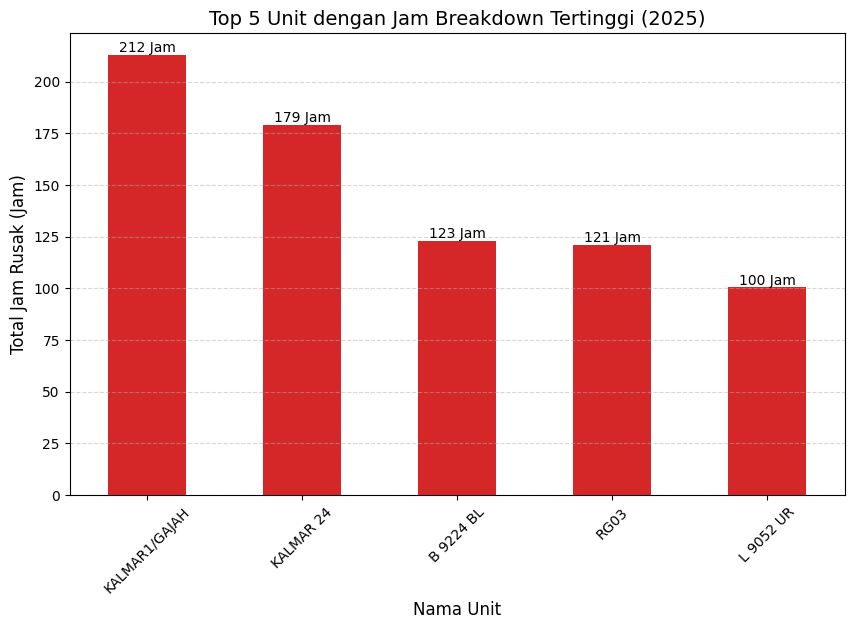

In [12]:
# Visualisasi: Top 5 Unit Paling Sering Rusak (Tahun 2025)
top_breakdown = ops_monthly.groupby('Unit_Clean')['TOTAL BREAKDOWN (HOURS)'].sum().nlargest(5)

plt.figure(figsize=(10, 6))
ax = top_breakdown.plot(kind='bar', color='#d62728') 

plt.title('Top 5 Unit dengan Jam Breakdown Tertinggi (2025)', fontsize=14)
plt.ylabel('Total Jam Rusak (Jam)', fontsize=12)
plt.xlabel('Nama Unit', fontsize=12)
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Menambahkan label angka
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())} Jam', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

# --- BAGIAN TAMBAHAN UNTUK SAVE GAMBAR ---
nama_file_2 = 'Grafik_Top_Breakdown_2025.png'
plt.savefig(nama_file_2, dpi=300, bbox_inches='tight')
print(f"✅ Grafik berhasil disimpan: {nama_file_2}")

plt.show()

In [ ]:
# PROSES LOAD DATA BBM (EXCEL MULTI-HEADER FIX)
nama_file_excel = "BBM AAB.xlsx"
full_path_bbm = os.path.join(path_folder_bbm, nama_file_excel)

print(f"Membaca file Excel (Mode Advanced): {full_path_bbm}...")

# Mapping Nama Sheet -> Format Tanggal (Periode)
bulan_map = {
    'JAN': '2025-01', 'FEB': '2025-02', 'MAR': '2025-03', 'APR': '2025-04',
    'MEI': '2025-05', 'JUN': '2025-06', 'JUL': '2025-07', 'AGT': '2025-08',
    'SEP': '2025-09', 'OKT': '2025-10', 'NOV': '2025-11', 'DES': '2025-12'
}

list_bbm = []

if os.path.exists(full_path_bbm):
    for nama_sheet, periode in bulan_map.items():
        try:
            # PENTING: header=None agar kita bisa membaca Baris 1, 2, 3 secara mentah
            df_raw = pd.read_excel(full_path_bbm, sheet_name=nama_sheet, header=None, engine='openpyxl')
                        
            # 1. Ambil Baris 0 (Nama Unit) dan isi cell yang kosong akibat Merged Cells
            # (Misal: "LINDE", NaN, NaN -> "LINDE", "LINDE", "LINDE")
            row_unit_names = df_raw.iloc[0].fillna(method='ffill')
            
            # 2. Ambil Baris 2 (Header Kolom: HM, LITER, KEGIATAN)
            row_headers = df_raw.iloc[2]
            
            # 3. Cari Index Kolom mana saja yang berisi kata "LITER"
            # Kita hanya peduli kolom "LITER", kolom lain (HM, FOTO) kita abaikan
            col_liter_indices = [i for i, x in enumerate(row_headers) if str(x).strip().upper() == 'LITER']
            
            if not col_liter_indices:
                print(f"Sheet '{nama_sheet}': Tidak ditemukan kolom 'LITER' di baris ke-3.")
                continue

            # 4. Ekstrak Data per Unit
            temp_list = []
            for col_idx in col_liter_indices:
                # Ambil Nama Unit dari Baris 0 di kolom yang sama
                unit_name = str(row_unit_names[col_idx]).strip().upper()
                
                # Ambil Data Angka dari Baris 3 ke bawah (Skip 3 baris header)
                # Pakai errors='coerce' supaya teks 'LIBUR'/'RUSAK' jadi 0
                data_liter = pd.to_numeric(df_raw.iloc[3:, col_idx], errors='coerce').fillna(0)
                
                total_liter = data_liter.sum()
                
                # Hanya simpan jika ada konsumsi solar
                if total_liter > 0:
                    temp_list.append({
                        'Month': periode,
                        'Unit_Clean': unit_name,
                        'LITER': total_liter
                    })
            
            # Masukkan ke list utama
            if temp_list:
                df_sheet = pd.DataFrame(temp_list)
                list_bbm.append(df_sheet)
                print(f"Sheet '{nama_sheet}': Berhasil ambil {len(df_sheet)} unit. (Total Liter: {df_sheet['LITER'].sum():,.0f})")
            else:
                print(f"Sheet '{nama_sheet}': Kolom LITER ada, tapi datanya kosong/0 semua.")

        except ValueError:
            # Error jika sheet belum ada (misal DES)
            print(f"Sheet '{nama_sheet}' tidak ditemukan (Skip).")
        except Exception as e:
            print(f"Error Sheet '{nama_sheet}': {e}")

    # GABUNGKAN HASILNYA
    if list_bbm:
        df_bbm_all = pd.concat(list_bbm, ignore_index=True)
        df_bbm_all['Month'] = pd.to_datetime(df_bbm_all['Month']).dt.to_period('M')
        
        print(f"Total Data BBM: {len(df_bbm_all)} Baris Transaksi")
        print(df_bbm_all.head())
    else:
        print("\nTidak ada data BBM yang berhasil diekstrak.")

else:
    print(f"ERROR: File tidak ditemukan di path: {full_path_bbm}")

Membaca file Excel (Mode Advanced): C:\Users\spil\Downloads\22 Des\Analisa-Penggunaan-Bahan-Bakar-Alat-Berat\BBM AAB.xlsx...


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'JAN': Berhasil ambil 188 unit. (Total Liter: 502,895)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'FEB': Berhasil ambil 187 unit. (Total Liter: 466,376)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'MAR': Berhasil ambil 188 unit. (Total Liter: 466,238)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'APR': Berhasil ambil 181 unit. (Total Liter: 422,028)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'MEI': Berhasil ambil 190 unit. (Total Liter: 542,408)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'JUN': Berhasil ambil 191 unit. (Total Liter: 494,899)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'JUL': Berhasil ambil 196 unit. (Total Liter: 541,236)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'AGT': Berhasil ambil 188 unit. (Total Liter: 550,461)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'SEP': Berhasil ambil 194 unit. (Total Liter: 555,313)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'OKT': Berhasil ambil 190 unit. (Total Liter: 571,887)


C:\Users\spil\AppData\Local\Temp\ipykernel_15464\1001746679.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_unit_names = df_raw.iloc[0].fillna(method='ffill')


Sheet 'NOV': Berhasil ambil 193 unit. (Total Liter: 531,247)
Sheet 'DES' tidak ditemukan (Skip).
Total Data BBM: 2086 Baris Transaksi
     Month  Unit_Clean     LITER
0  2025-01       LINDE  10639.77
1  2025-01   KALMAR 32  14122.45
2  2025-01  KONECRANES   9069.64
3  2025-01         SMV   3863.67
4  2025-01   KALMAR 20   3825.00


In [ ]:
# Merge Outer Join
df_final = pd.merge(ops_monthly, df_bbm_all, on=['Unit_Clean', 'Month'], how='outer')

# Isi NaN dengan 0
cols_to_fix = ['Daily_HM', 'TOTAL BREAKDOWN (HOURS)', 'LITER', 'MA_Score']
for col in cols_to_fix:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(0)

# Hitung Efisiensi
def hitung_eff(row):
    if row['Daily_HM'] > 0:
        return row['LITER'] / row['Daily_HM']
    else:
        return 0

df_final['Efisiensi'] = df_final.apply(hitung_eff, axis=1)

# Simpan ke Excel untuk dicek manual
df_final.to_excel("Final_Analisa_BBM_HMU_2025.xlsx", index=False)
print("File output: 'Final_Analisa_BBM_HMU_2025.xlsx'")
print(df_final.head())

Data Selesai Digabung! File output: 'Final_Analisa_BBM_HMU_2025.xlsx'
  Unit_Clean    Month  Daily_HM  TOTAL BREAKDOWN (HOURS)  Date  \
0     AKASIA  2025-01      64.0                      0.0  31.0   
1     AKASIA  2025-02      47.0                      2.5  28.0   
2     AKASIA  2025-03      10.0                      0.0  31.0   
3     AKASIA  2025-04      24.0                     10.5  30.0   
4     AKASIA  2025-05      28.0                      0.0  31.0   

   Available_Hours    MA_Score   LITER  Efisiensi  
0            744.0  100.000000  463.59   7.243594  
1            672.0   99.627976  341.67   7.269574  
2            744.0  100.000000  139.29  13.929000  
3            720.0   98.541667   98.00   4.083333  
4            744.0  100.000000  150.64   5.380000  


✅ Grafik berhasil disimpan: Grafik_Tren_Efisiensi_2025.png


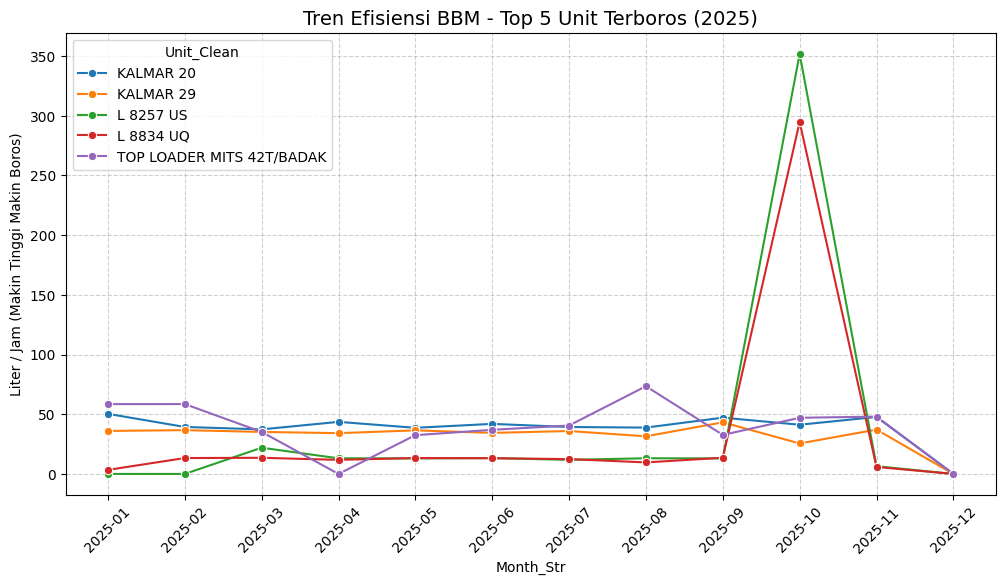

In [ ]:
# Ambil Top 5 Unit Paling Boros
top_boros = df_viz.groupby('Unit_Clean')['Efisiensi'].mean().nlargest(5).index

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_viz[df_viz['Unit_Clean'].isin(top_boros)], 
             x='Month_Str', y='Efisiensi', hue='Unit_Clean', marker='o')

plt.title('Tren Efisiensi BBM - Top 5 Unit Terboros (2025)', fontsize=14)
plt.ylabel('Liter / Jam (Makin Tinggi Makin Boros)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# --- BAGIAN TAMBAHAN UNTUK SAVE GAMBAR ---
nama_file_1 = 'Grafik_Tren_Efisiensi_2025.png'
# bbox_inches='tight' agar tulisan di pinggir tidak terpotong
plt.savefig(nama_file_1, dpi=300, bbox_inches='tight') 
print(f"Grafik berhasil disimpan: {nama_file_1}")

plt.show()